In [99]:
from numpy import *
# from matplotlib.pyplot import *
# import os
# ion()

# find hinges
def splitHinge(vals, sites, block):
    # split hinges
    currBlock = 1
    index = 0
    isStart = False
    newSites = []
    newVals = []

    for val in vals:
        if block[index] == currBlock and not isStart:
            isStart = True
            currSites = [sites[index]]
            currValLists = [vals[index]]
        elif block[index] == currBlock and isStart:
            currSites.append(sites[index])
            currValLists.append(vals[index])
        else:
            currBlock += 1
            isStart = True
            newSites.append(currSites)
            newVals.append(currValLists)
            currSites = [sites[index]]
            currValLists = [vals[index]]
        if currBlock == block[-1] and index == len(vals) - 1:
            newSites.append(currSites)
            newVals.append(currValLists)
        index += 1
    # print newSites, newVals
    return newSites, newVals


def mini(a, b):
    if a > b:
        return a
    else:
        return b


def checkIfCrossBase(currVal, currSite, currEigenVec):
    identify = sort(currVal)
    ifRemain = True
    if identify[0] < 0 and identify[-1] > 0:
        ifRemain = True
    else:
        maxSite = max(currSite)
        minSite = min(currSite)
        # print (identify)
        if identify[0] >= 0 and identify[-1] >= 0:
            if currEigenVec[max(0, minSite - 1)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 1)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 2)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 3)] < 0:
                ifRemain = True
            else:
                ifRemain = False
        elif identify[0] <= 0 and identify[-1] <= 0:
            # print (len(currEigenVec))
            # print (currEigenVec[239])

            if currEigenVec[max(0, minSite - 1)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 1))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 2))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 3))] > 0:
                ifRemain = True
            else:
                ifRemain = False

        else:
            print(identify[0], identify[-1])
            print("Check!")
    return ifRemain


def oneModeHinge(currEigenVec, thereshold=20):
    range = ((1 / float(len(currEigenVec))) ** 0.5) / thereshold
    # print (range)
    # print range
    sites = []
    vals = []
    block = []

    index = 0
    blockID = 1
    for item in currEigenVec:
        if item <= range and item >= -range:
            vals.append(item)
            if len(sites) >= 1 and abs(sites[-1] - index) > 1:
                blockID += 1
            sites.append(index)
            block.append(blockID)
        index += 1

    newSites, newVals = splitHinge(vals, sites, block)

    filtSites = []
    filtVals = []

    index = 0
    for item in newSites:
        currSite = newSites[index]
        currVal = newVals[index]
        if checkIfCrossBase(currVal, currSite, currEigenVec):
            filtSites.append(currSite)
            filtVals.append(currVal)
        index += 1

    return filtSites, filtVals


def getValue(currList):
    newList = []
    for item in currList:
        newList.append(float(item))
    return newList


def readModes(fileName):
    allModes = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.strip()
            line = line.split('\t')
            currMode = line[0]
            currVal = line[1:]
            allModes[currMode] = getValue(currVal)
    return allModes


def flattenData(arrayTwoD):
    flat = []
    for item in arrayTwoD:
        for each in item:
            flat.append(each)
    return flat

def cleanStr(currStr):
    return currStr.strip('\'')

def readFile(fileName):
    data = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.replace('\n', '')
            line = line.strip()
            line = line.split('\t')
            currPDB = line[0]
            currDrug = line[1]
            currChain = line[2:]
            if currPDB not in data.keys():
                data[currPDB] = {}
            if currDrug not in data[currPDB].keys():
                data[currPDB][currDrug] = []
            for each in currChain:
                data[currPDB][currDrug].append(cleanStr(each))
    return data

# contribution of mode of motions
def getContribution(eigenVals, mode):
    allContribution = sqrt(sum(1 / eigenVals))
    currModeContribution = eigenVals[:mode]
    currContribution = sqrt(sum(1 / currModeContribution))
    return currContribution / allContribution

def getModesGivenThreshold(eigenVals, thereshold):
    contribution = 0
    mode = 0
    while contribution <= thereshold:
        mode += 1
        contribution = getContribution(eigenVals, mode)
    return mode

def writeBinding(fileName, pdb_ids):
    with open(fileName, 'w') as wf:
        for item in pdb_ids:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')


from prody import *
def getModes(currPDB, eachChain, length = 0.7, rmsd = 1.0, Z = 10):    
    # if not os.path.exists('./Results/' + currPath):
    #     os.mkdir('./Results/' + currPath)
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len = length, cutoff_rmsd = rmsd, cutoff_Z = Z)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    
    ags = parsePDB(pdb_ids, subset='ca')
    dali_ens = buildPDBEnsemble(ags, mapping=mappings, seqid=20)
    gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
    eigVals = gnms.getEigvals()
    averageEigVals = eigVals[0]

    eigVects = gnms.getEigvecs()
    averageEigVects = mean(eigVects, axis=0)
    return averageEigVals, averageEigVects, pdb_ids, gnms

            
def getDali_info(currPDB, eachChain, rmsd = 2.5, length = 0.9):
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len=length, cutoff_rmsd=rmsd)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    return pdb_ids, mappings

def getHinges(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge


def getHinges_modes(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def get3Hinges_bandwidth(averageEigVects, bandWidths = [15, 16, 17]):
    currHinge = []
    for i in range(3):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidths[i])
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [2]:
def oneModeHinge_update(values, thereshold=20):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    # print (regions)
    
    FinalRegions = []
    for region in regions:
        # print ('before filtering', region)
        if len(region) >= 5:
            # print ('previous region', region)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            n = int(len(region) / 4) + 1
            region = pos[:n] + neg[:n]
            # print (region, neg, pos)
        elif 3 <= len(region) <= 4:
            if values[region[0]-1] * values[region[-1]+1] > 0:
                continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    # print ('Final regions', FinalRegions)
    
    flat = flattenData(FinalRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return FinalRegions, final_values

def getHinges2(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

def getHinges_modes2(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge



In [3]:
# Experiment to evaluate performance of hypergeometric p values
from scipy.stats import hypergeom
def ORA(M, N, n, k):
    total = 0
    totalLength = N
    binding = M
    hinge = n
    overlap = k
    
    for i in range(overlap):
        total += hypergeom.pmf(i, totalLength, binding, hinge)
    return 1 - total


import os
def writeIDs(path, idList):
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:

       # Create a new directory because it does not exist
       os.makedirs(path)
       print("The new directory is created!")
    
    with open(path + '/ids_diverse.txt', 'w') as wf:
        for item in idList:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')

In [4]:
def writeNumbers(path, numbers):
    with open(path, 'w') as wf:
        for item in numbers:
            wf.write(str(item) + '\n')

def merge_overlapping_lists(lists):
    sorted_lists = sorted(lists, key=lambda x: x[0])  # Sort lists based on the first element
    merged_lists = [sorted_lists[0]]
    
    for current in sorted_lists[1:]:
        previous = merged_lists[-1]
        # Check if the current list overlaps with the previous one
        if current[0] <= previous[-1]:
            # Merge overlapping lists by updating the last list in merged_lists
            merged_lists[-1] = list(range(min(previous[0], current[0]), max(previous[-1], current[-1])+1))
        else:
            merged_lists.append(current)
    return merged_lists

# Method3

In [5]:
def trimEnds(values, lists):
    begining = 4
    ends = len(values) - 5
    isInclude = True
    for item in lists:
        if item < begining or item > ends:
            isInclude = False
    return isInclude

def splitRegions(currlist):
    sortList = sort(currlist)
    
    region_list = []
    currRegion = []
    previous = -1
    for item in sortList:
        if item - previous == 1:
            currRegion.append(item)
            previous = item
        else:
            if currRegion != []:
                region_list.append(currRegion)
            currRegion = [item]
            previous = item
    
    if currRegion not in region_list:
        region_list.append(currRegion)
    return region_list
        
def extendRegions(crossovers, values, thereshold):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    return regions

def mergeRegions(lists, max_gap=2, min_length=5):
    merged = [lists[0]]  # Start with the first list

    for next_list in lists[1:]:
        # Check if the next list starts within max_gap+1 of the last element of the current last list in 'merged'
        if next_list[0] - merged[-1][-1] <= max_gap + 1:
            # Merge the lists by extending the last list in 'merged' with the elements of 'next_list'
            merged[-1].extend(next_list)
        else:
            # If it doesn't meet the merge criteria, just append the list as a new one
            merged.append(next_list)

    # Filter merged lists to ensure they meet the min_length requirement after removing duplicates and sort them
    # Keep unmerged lists as they are
    final_list = []
    for sublist in merged:
        unique_sublist = sorted(set(sublist))  # Remove duplicates and sort
        if len(unique_sublist) >= min_length or unique_sublist == sublist:  # Check length or unchanged list
            final_list.append(unique_sublist)
        else:
            # For lists that were attempted to merge but didn't meet the length requirement,
            # revert to individual elements as separate lists
            final_list.extend([[item] for item in unique_sublist])

    # print (final_list)
    finals = []
    for item in final_list:
        if len(item) < min_length:
            finals += splitRegions(item)
        else:
            finals.append(item)
    
    return finals

# Function to trim similar sign values from start
def trim_start(lst, index):
    if len(lst) == 1:
        return lst, index
    if not lst:
        return [], []
    start_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != start_sign:
            return lst[i-1:], index[i-1:]
    return [], []

# Function to trim similar sign values from end
def trim_end(lst, index):
    if len(lst) == 1:
        return lst, index
    
    if not lst:
        return [], []
    lst = lst[::-1]  # Reverse the list for ease of use
    index = index[::-1]
    end_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != end_sign:
            return lst[i-1:][::-1], index[i-1:][::-1]  # Reverse the list again to restore original order
    return [], []

def trimRegions(region, values):
    newRegion = []
    for eachIndex in region:
        currValues = [values[x] for x in eachIndex]
        # print (eachIndex, currValues)
        # Apply the trimming functions
        trimmed_start, trimmed_index = trim_start(currValues, eachIndex)
        # print (trimmed_index)
        trimmed_end, trimmed_index = trim_end(trimmed_start, trimmed_index)
        newRegion.append(trimmed_index)
    return newRegion

def findSmallestPairs(index_list, value_list):
    # Initialize variables to store the smallest sum and corresponding indices
    smallest_sum = float('inf')  # Set it to infinity initially
    smallest_pair = None

    # Iterate through the value list to find adjacent index pairs with the smallest sum of absolute values
    for i in range(len(value_list) - 1):  # -1 because we are looking at pairs
        current_sum = abs(value_list[i]) + abs(value_list[i + 1])
        if current_sum < smallest_sum:
            smallest_sum = current_sum
            smallest_pair = [index_list[i], index_list[i + 1]]
    return smallest_pair

def find_cross_points(Final_test, crossovers, values):
    crossoverPoints_pairs = []
    for item in Final_test:
        if item in crossovers and item - 1 in Final_test:
            crossoverPoints_pairs.append([item - 1, item])
    
    # print ('cross_pairs', crossoverPoints_pairs)
    # filtering_pairs = mergeRegions(crossoverPoints_pairs, max_gap=0, min_length=3)
    # currNumber = len(filtering_pairs) * 2
    # print ('filtering_pairs', crossoverPoints_pairs)
    
    bestPairs = crossoverPoints_pairs[0]
    bestScore = abs(values[bestPairs[0]]) + abs(values[bestPairs[1]])
    if len(crossoverPoints_pairs) <= 1:
        return bestPairs
    else:
        for item in crossoverPoints_pairs[1:]:
            currScore = abs(values[item[0]]) + abs(values[item[1]])
            # print ('item, score', item, currScore)
            if currScore <= bestScore:
                bestPairs = item
                bestScore = currScore
    
    # print ('filtered', bestPairs)
    return bestPairs

def filteringCriteria(Final, values, crossovers):
    FinalRegions = []
    for region in Final:
        # print ('before filtering', region)
        if len(region) >= 5:
            allPairs = find_cross_points(region, crossovers, values)
            currRegion = allPairs
            
            # print ('allPairs', allPairs)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            extra = round((len(region) - 2) / 4 + 0.00001)
            
            # rest = pos[1:] + neg[1:]
            # restValues = [values[res] for res in rest]
            # combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            rest = []
            for item in region:
                if item not in currRegion:
                    rest.append(item)
            restValues = [values[res] for res in rest]   
            combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            
            # Extract the sorted indexes from the combined list
            sorted_indexes = [index for index, value in combined_list]
            
            region = currRegion + sorted_indexes[:extra]
            # print (region)
            
        elif 3 <= len(region) <= 4:
            region = find_cross_points(region, crossovers, values)
            # print (region)
            # if values[region[0]-1] * values[region[-1]+1] > 0:
            #     continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        
        # print ('after filtering',region)      
        elif len(region) == 1:
            continue
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    return FinalRegions

In [6]:
def oneModeHinge_update2(values, hinges, thereshold=20):
    # band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    regions = extendRegions(crossovers, values, thereshold)
    # print ('extend Regions', regions)
    
    # merge regions and hinges
    flat = sort(list(set(flattenData(regions) + hinges)))
    Final = splitRegions(flat)
    # print ('before merging', Final)
    Final = mergeRegions(Final, max_gap=2, min_length=5)
    # print ('Final is', Final)
    # trim Regions
    trimmedFinal = trimRegions(Final, values)
    # print ('after trimming', trimmedFinal)
    
    FinalRegions = filteringCriteria(trimmedFinal, values, crossovers)
    # print ('after filtering', FinalRegions)
    
    # remove frist and last several residues as hinges
    updateRegions = []
    for currReg in FinalRegions:
        if trimEnds(values, currReg):
            updateRegions.append(currReg)
    
    # print (updateRegions)
        
    flat = flattenData(updateRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return updateRegions, final_values

In [7]:
def getHinges_modes3(averageEigVects, mode, hinges, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update2(averageEigVects[:, mode], hinges, thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def getHinges3(averageEigVects, currNumModes, hinges, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update2(averageEigVects[:, i], hinges[i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [51]:
# remove first and last hinges for each chain
def filterTwoEnds(hinges, chainLength = [[0, 551], [552, 956]]):
    FilteringIndex = []
    trimmingLength = 15
    for item in chainLength:
        # print (item)
        FilteringIndex += list(range(item[0], item[0] + trimmingLength))
        FilteringIndex += list(range(item[1] - trimmingLength + 1, item[1] + 1))  
    updateHinges = []
    for item in hinges:
        if item not in FilteringIndex:
            updateHinges.append(item)
    
    return updateHinges

# Diverse ensemble

In [100]:
currPDB = '2x92'
eachChain = 'A'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals, averageEigVects, ids, gnms= getModes(currPDB, eachChain, length=0.95, rmsd=1, Z=10)


@> Submitted Dali search for PDB "2x92A".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//2x92A/
@> Dali results were fetched in 0.2s.   
@> Obtained 737 PDB chains from Dali for 2x92A.
@> 222 PDBs have been filtered out from 737 Dali hits (remaining: 515).
@> Retrieving 2x92A... [  0%]

# of similar structures is found from Dali 515


@> Retrieving 7ydiA... [ 73%] 56s @> WARNING 7ydi download failed ('https://files.rcsb.org/download/7YDI.pdb.gz' could not be opened for reading, invalid URL or no internet connection).
@> WARNING Trying to parse mmCIF file instead
@> WARNING Could not find _pdbx_branch_scheme in lines.
@> WARNING DBREF for chain L refers to PDB entry 7YDI (7YDI
:4)
@> WARNING DBREF for chain L refers to PDB entry 7YDI (7YDI
:4)
@> WARNING Could not find _pdbx_struct_mod_residue in lines.
@> WARNING Could not find _entity_name_com in lines.
@> WARNING DBREF for chain L refers to PDB entry 7YDI (7YDI
:4)
@> WARNING DBREF for chain L refers to PDB entry 7YDI (7YDI
:4)
@> WARNING Could not find _pdbx_struct_mod_residue in lines.
@> WARNING Could not find _entity_name_com in lines.
@> Retrieving 7ya0E... [ 87%] 27s@> WARNING 7ya0 download failed ('https://files.rcsb.org/download/7YA0.pdb.gz' could not be opened for reading, invalid URL or no internet connection).
@> WARNING Trying to parse mmCIF file inste

@> WARNING last 13 modes for 568 modes from MaskedGNM 7q27A_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 10 modes for 568 modes from MaskedGNM 5amaD_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 2xydA_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 13 modes for 568 modes from MaskedGNM 4ca6B_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 10 modes for 568 modes from MaskedGNM 6tt1A_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 5am8B_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 11 modes for 568 modes from MaskedGNM 6f9vA_ca reduced has been discarded because at least one conformation has only 568 modes

@> WARNING last 13 modes for 568 modes from MaskedGNM 7efpA_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 6h5xB_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 5amcB_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 10 modes for 568 modes from MaskedGNM 7z6zB_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 5ambA_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 11 modes for 568 modes from MaskedGNM 6qs1A_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 5am9D_ca reduced has been discarded because at least one conformation has only 568 modes

@> WARNING last 13 modes for 568 modes from MaskedGNM 8spiB_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 6zpqA_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 13 modes for 568 modes from MaskedGNM 7rpvD_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 13 modes for 568 modes from MaskedGNM 7rpvC_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 13 modes for 568 modes from MaskedGNM 7rpvB_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 13 modes for 568 modes from MaskedGNM 8sphB_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 13 modes for 568 modes from MaskedGNM 3sckB_ca reduced has been discarded because at least one conformation has only 568 modes

@> WARNING last 12 modes for 568 modes from MaskedGNM 8bn1A_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 13 modes for 568 modes from MaskedGNM 8h5cA_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 8dljE_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 7sy6E_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 7t9kE_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 7vx5A_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 7xb0A_ca reduced has been discarded because at least one conformation has only 568 modes

@> WARNING last 10 modes for 568 modes from MaskedGNM 8u0tA_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 13 modes for 568 modes from MaskedGNM 7vxdC_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 7sy3E_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 11 modes for 568 modes from MaskedGNM 8dm8D_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 10 modes for 568 modes from MaskedGNM 7xb1A_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 8dlpD_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 13 modes for 568 modes from MaskedGNM 3d0gA_ca reduced has been discarded because at least one conformation has only 568 modes

@> WARNING last 12 modes for 568 modes from MaskedGNM 1r42A_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 8 modes for 568 modes from MaskedGNM 7xo6D_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 8hrnA_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 11 modes for 568 modes from MaskedGNM 7kniF_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 7wpbD_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 8 modes for 568 modes from MaskedGNM 7xobE_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 11 modes for 568 modes from MaskedGNM 7kniD_ca reduced has been discarded because at least one conformation has only 568 modes
@

@> WARNING last 8 modes for 568 modes from MaskedGNM 7p19A_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 11 modes for 568 modes from MaskedGNM 7df4A_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 13 modes for 568 modes from MaskedGNM 7wpcD_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 5 modes for 568 modes from MaskedGNM 7kj4F_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 11 modes for 568 modes from MaskedGNM 8iouD_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 1 modes for 568 modes from MaskedGNM 7r11D_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 9 modes for 568 modes from MaskedGNM 8i9dF_ca reduced has been discarded because at least one conformation has only 568 modes
@> 

@> WARNING last 8 modes for 568 modes from MaskedGNM 7dx9D_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 7 modes for 568 modes from MaskedGNM 7dx6D_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 8 modes for 568 modes from MaskedGNM 7v89G_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 9 modes for 568 modes from MaskedGNM 7v82E_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 13 modes for 568 modes from MaskedGNM 7yj3A_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 11 modes for 568 modes from MaskedGNM 8i9eA_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 4 modes for 568 modes from MaskedGNM 7r12D_ca reduced has been discarded because at least one conformation has only 568 modes
@> W

@> WARNING last 11 modes for 568 modes from MaskedGNM 7wvpA_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 12 modes for 568 modes from MaskedGNM 7wk5A_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 10 modes for 568 modes from MaskedGNM 7yeg_J_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 11 modes for 568 modes from MaskedGNM 7wrhD_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 3 modes for 568 modes from MaskedGNM 7a98F_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 4 modes for 568 modes from MaskedGNM 7a95D_ca reduced has been discarded because at least one conformation has only 568 modes
@> WARNING last 5 modes for 568 modes from MaskedGNM 7a96D_ca reduced has been discarded because at least one conformation has only 568 modes
@

In [101]:
averageEigVects.shape

(598, 568)

In [11]:
writeIDs('./Binding', ids)

In [102]:
currNumModes = getModesGivenThreshold(averageEigVals, 0.33)
currNumModes

4

In [225]:
binding = [86, 87, 88, 89, 108, 187, 188, 190, 191, 249, 250, 321, 322, 323, 324, 325, 327, 347, 348, 351, 352, 355, 359, 362, 370, 371, 372, 378, 379, 383, 422, 425, 479, 480, 481, 484, 486, 487, 488, 490, 491, 494, 495]
print ([x + 16 for x in binding])


[102, 103, 104, 105, 124, 203, 204, 206, 207, 265, 266, 337, 338, 339, 340, 341, 343, 363, 364, 367, 368, 371, 375, 378, 386, 387, 388, 394, 395, 399, 438, 441, 495, 496, 497, 500, 502, 503, 504, 506, 507, 510, 511]


In [260]:
bindings = ['243', '249', '265', '315', '316', '317', '318', '321', '322', '323', '337', '338', '339', '341', '342', '345', '346', '351', '352', '355', '364', '367', '368', '373', '379', '419', '425', '441', '473', '474', '475', '479', '480', '481', '482', '484', '485', '488', '489', '491', '495', '497', '504', '507', '511']
binding = [int(x) for x in bindings]

# bindings = [44, 47, 62, 69, 102, 103, 104, 105, 113, 117, 124, 197, 203, 204, 206, 207, 265, 266, 337, 338, 339, 340, 341,342,344,360,363,364,367,368,371,375,378,386,387,388,391,394,395,399,402,437,438,441,444,495,496,497,500,501,502,503,504,506,507,511]

bindings = [102,103,104,105,124,203,204,205,206,207,265,266,337,338,339,340,341,343,363,364,367,368,371,375,378,386,387,388,394,399,438,441,495,496,497,500,502,503,504,506,507,510,511]
binding = [x - 16 for x in bindings] # aasn14 and basn14 duplicated

# binding = [86, 87, 88, 89, 108, 187, 188, 190, 191, 249, 250, 321, 322, 323, 324, 325, 327, 347, 348, 351, 352, 355, 359, 362, 370, 371, 372, 378, 379, 383, 422, 425, 479, 480, 481, 484, 486, 487, 488, 490, 491, 494, 495]


In [308]:
Hinges_2 = getHinges(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges(averageEigVects, 3, 20)

Hinges_4 = getHinges(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges(averageEigVects, 3, 15)


In [309]:
print(sort([x + 16 for x in binding]))

[102 103 104 105 124 203 204 206 207 265 266 337 338 339 340 341 343 363
 364 367 368 371 375 378 386 387 388 394 395 399 438 441 495 496 497 500
 502 503 504 506 507 510 511]


In [310]:
Hinges_2 = filterTwoEnds(Hinges_2, chainLength = [[0, 598]])
Hinges_3 = filterTwoEnds(Hinges_3, chainLength = [[0, 598]])
Hinges_4 = filterTwoEnds(Hinges_4, chainLength = [[0, 598]])
Hinges_5 = filterTwoEnds(Hinges_5, chainLength = [[0, 598]])

In [311]:
ORA(43, 598, 80, 12)

0.006783086976421937

In [312]:
protein_length = 598

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)

# of binding sites is 43
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 69 10 0.018070329153059173
# of hinge sites for first 3 modes, overlap, hyper score 49 8 0.01776014823938743
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 81 12 0.0075413650186497705
# of hinge sites for first 3 modes, overlap, hyper score 57 9 0.014624321601896861


In [313]:
Badren = parsePDB('2x92', subset='calpha')
calphas = Badren.select('calpha and chain A B')
gnm = GNM('b-adren')
gnm.buildKirchhoff(calphas)
gnm.calcModes(n_modes=None)
Hinge0 = calcHinges(gnm[0])
Hinge1 = calcHinges(gnm[1])
Hinge2 = calcHinges(gnm[2])
Hinge3 = calcHinges(gnm[3])

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 2x92 downloaded (2x92.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 598 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Secondary structures were assigned to 444 residues.
@> Kirchhoff was built in 0.03s.
@> 597 modes were calculated in 0.18s.


In [314]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 43
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 140 15 0.05277483300756092
# of hinge sites for 3 modes, overlap, hyper score 102 12 0.04541557899135673
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 151 17 0.023146116474973555
# of hinge sites for 3 modes, overlap, hyper score 109 13 0.033094327444246674


## writeResults

In [315]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)
len(MSF)

598

In [316]:
values_array = np.array(sqrt(MSF))

# Get indices of the 5 smallest values
indices = np.argsort(values_array)

if not os.path.exists('./Data'):
    os.mkdir('./Data')

writeNumbers('./Data/RMSF_minimum.txt', indices)

In [317]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [318]:
modes = [0, 1, 2]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes(averageEigVects, mode, bandWidth=20)
    currHinge = filterTwoEnds(currHinge, chainLength = [[0, 598]])
    
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [319]:
curr = list(curr)
def writeAllData(path, curr):
    with open(path, 'w') as wf:
        for row in curr:
            for col in row:
                if col == 0.0:
                    wf.write('' + '\t')
                else:
                    wf.write(str(col) + '\t')
            wf.write('\n')
                
writeAllData('./Data/ACE_Method1.txt', curr)

## Method 2

In [332]:
Hinges_2 = getHinges2(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges2(averageEigVects, 3, 20)

Hinges_4 = getHinges2(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges2(averageEigVects, 3, 15)

In [333]:
Hinges_2 = filterTwoEnds(Hinges_2, chainLength = [[0, 598]])
Hinges_3 = filterTwoEnds(Hinges_3, chainLength = [[0, 598]])
Hinges_4 = filterTwoEnds(Hinges_4, chainLength = [[0, 598]])
Hinges_5 = filterTwoEnds(Hinges_5, chainLength = [[0, 598]])

In [334]:
protein_length = 598

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 43
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 111 15 0.006259988590418986
# of hinge sites for first 3 modes, overlap, hyper score 80 12 0.006783086976421937
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 115 16 0.0032471449612455627
# of hinge sites for first 3 modes, overlap, hyper score 81 12 0.0075413650186497705


In [335]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

Hinges_sep2 = filterTwoEnds(Hinges_sep2, chainLength = [[0, 598]])
Hinges_sep3 = filterTwoEnds(Hinges_sep3, chainLength = [[0, 598]])
Hinges_sep4 = filterTwoEnds(Hinges_sep4, chainLength = [[0, 598]])
Hinges_sep5 = filterTwoEnds(Hinges_sep5, chainLength = [[0, 598]])

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 43
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 172 18 0.03934835047325591
# of hinge sites for 3 modes, overlap, hyper score 131 15 0.030111183833966493
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 175 19 0.022305432757393162
# of hinge sites for 3 modes, overlap, hyper score 131 15 0.030111183833966493


In [336]:
AverageEigVals1 = gnms.getEigvals()[0]
AverageEigVals2 = mean(gnms.getEigvals(), axis=0)
proteinLength = 598

In [337]:
currHinge = Hinges_5

In [338]:
Segment = int(proteinLength / 5)
print ('mark Index are', 0, Segment, Segment*2, Segment*3, Segment*4, proteinLength - 1)

mark Index are 0 119 238 357 476 597


In [339]:
Labels = ['17', '136', '255', '374', '493', '614']

# of hinges 81
# of bindings sites 43
# of hits are 12


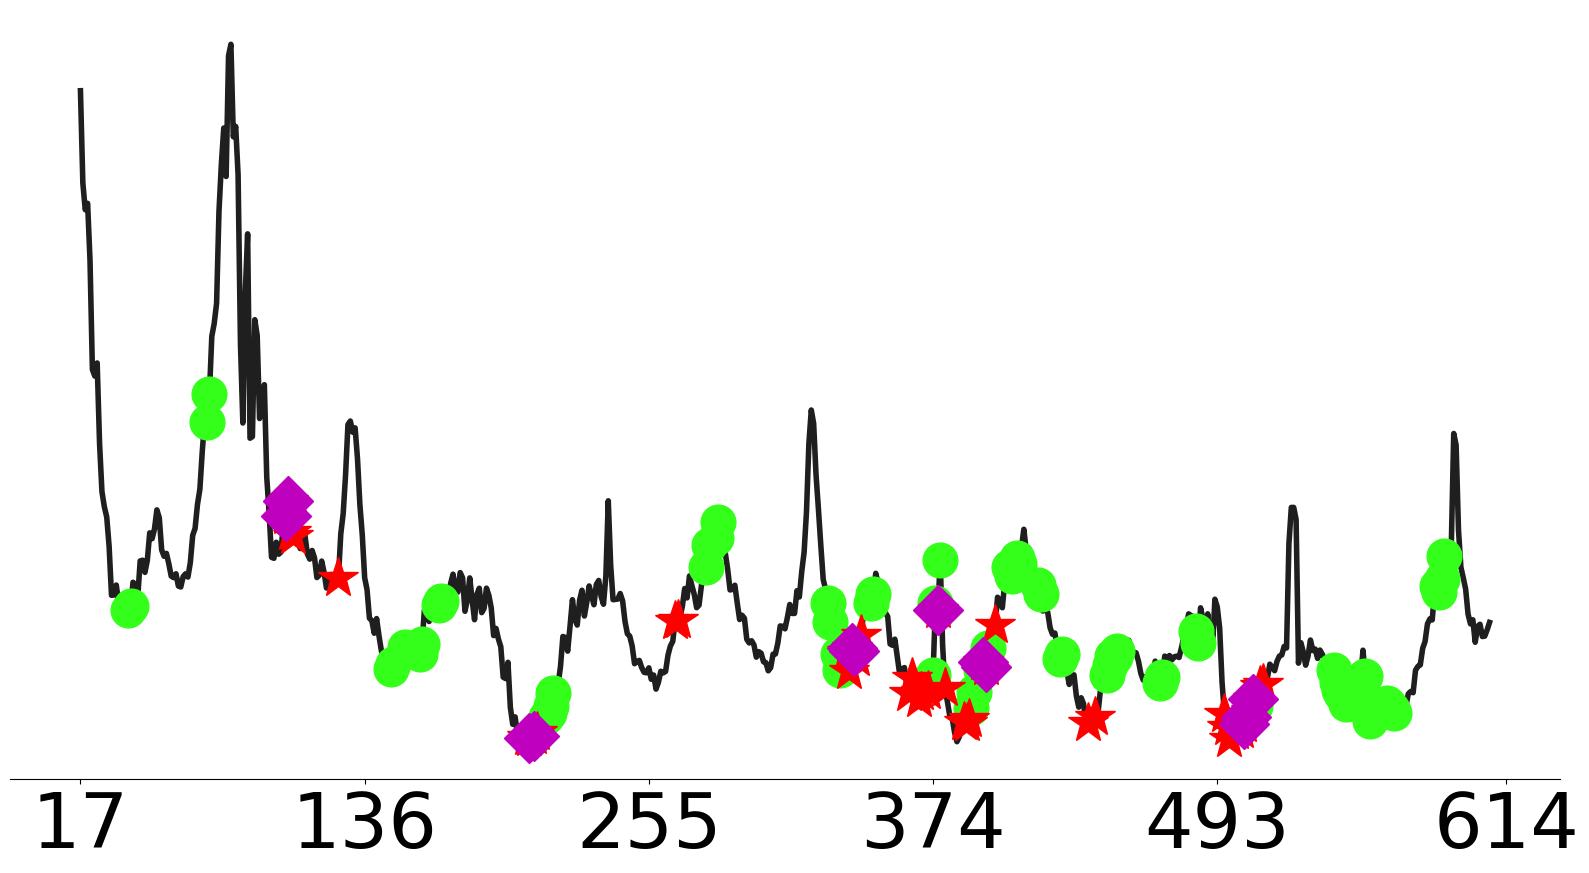

In [346]:
fig, ax = plt.subplots(figsize=(20, 10))   # Adjust size as per requirement
plt.sca(ax)  # Set current axis to 'ax'
    
# Increase font sizes
plt.rc('xtick', labelsize=55)
plt.rc('ytick', labelsize=50)
plt.rcParams.update({'font.size': 70})

# calcMSF
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / AverageEigVals1[mode]
    MSF.append(currMSF)

MSF = MSF[7:]
# plt.plot(MSF, color='#3B9EFF', linewidth=3, alpha=0.7)
plt.plot(MSF, color='black', linewidth=4, alpha=0.88)

HingeY = [MSF[item] for item in currHinge]
plt.plot(currHinge, HingeY, color=(0.2, 1, 0.1), marker='o', linestyle='', markersize=25)
print ('# of hinges', len(HingeY))

# plot binding sites
bindingY = [MSF[item] for item in binding]
plt.plot(binding, bindingY, 'r*', markersize=30)
print ('# of bindings sites', len(binding))

# plot overlaps
allHinge = currHinge
overlaps = [item for item in binding if item in allHinge]
overlapsY = [MSF[item] for item in overlaps]
plt.plot(overlaps, overlapsY, 'mD', markersize=25)

print ('# of hits are', len(overlaps))

# Hide y labels
plt.gca().yaxis.set_visible(False)

# Hide top, right, and left spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)


# Set x-axis labels and title with Arial font
# plt.title('Angiotensin I-converting Enzyme')
plt.xticks([0, Segment, Segment*2, Segment*3, Segment*4, proteinLength - 1], Labels)

plt.savefig('./ACE_MSF.png', dpi=500)

In [347]:
AverageEigVals1

sdarray([ 0.49379424,  0.67820789,  0.96307703,  1.27737014,  1.57552858,
          1.76903966,  1.99242324,  2.15587102,  2.36367431,  2.69430101,
          2.93465429,  3.03777153,  3.31287164,  3.34132967,  3.52584402,
          3.75975563,  3.98522967,  4.30659907,  4.46445156,  4.57421473,
          4.63692697,  4.88370231,  5.09324203,  5.40641815,  5.67145493,
          5.83215909,  6.02077969,  6.19584134,  6.39211636,  6.58368047,
          6.65295714,  6.79500453,  6.87499354,  6.94279364,  7.04097676,
          7.08544442,  7.25609696,  7.48812535,  7.59518507,  7.73051671,
          8.00265954,  8.07157831,  8.22968618,  8.35338538,  8.57280482,
          8.66652817,  8.78194881,  8.89976021,  8.90510405,  9.        ,
          9.05945555,  9.1590476 ,  9.26844285,  9.34215729,  9.44193234,
          9.50918429,  9.57841611,  9.64214734,  9.67005275,  9.81617953,
          9.82891255,  9.93178458, 10.02870603, 10.13559366, 10.16459   ,
         10.19226147, 10.22551357, 10.

## writeResults

In [348]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)

In [349]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [350]:
modes = [0, 1, 2]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=20)
    currHinge = filterTwoEnds(currHinge, chainLength = [[0, 598]])
    
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [351]:
writeAllData('./Data/ACE_Method2.txt', curr)

# method3

In [184]:
Hinges_2 = getHinges3(averageEigVects, currNumModes, [Hinge0, Hinge1,Hinge2,Hinge3], 20)
Hinges_3 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 20)

Hinges_4 = getHinges3(averageEigVects, currNumModes, [Hinge0, Hinge1,Hinge2,Hinge3], 15)
Hinges_5 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 15)

In [185]:
Hinges_2 = filterTwoEnds(Hinges_2, chainLength = [[0, 598]])
Hinges_3 = filterTwoEnds(Hinges_3, chainLength = [[0, 598]])
Hinges_4 = filterTwoEnds(Hinges_4, chainLength = [[0, 598]])
Hinges_5 = filterTwoEnds(Hinges_5, chainLength = [[0, 598]])

In [186]:
protein_length = 598

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)

# of binding sites is 43
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 105 13 0.024615706784473335
# of hinge sites for first 3 modes, overlap, hyper score 71 9 0.055526740220863346
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 105 13 0.024615706784473335
# of hinge sites for first 3 modes, overlap, hyper score 71 9 0.055526740220863346


# Write Modes

In [36]:
def writeModesAsBfactors(mode, eigenVects):
    residue = []
    new_b_factor = []
    chain = 'A'

    resiIndex = 4
    for item in eigenVects[:, mode]:
        resiIndex += 1
        residue.append(resiIndex)
        new_b_factor.append(item)

    with open('./Structure_demo/ALB_b_mode' + str(mode + 1) + '.txt', 'w') as wf:
        for i in range(len(residue)):
            wf.write(chain + ', ' + str(residue[i]) + ', ' + str(new_b_factor[i]) + '\n')

In [37]:
writeModesAsBfactors(0, eigenVects)
writeModesAsBfactors(1, eigenVects)

# Plot graphs

In [187]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import numpy as np

def format_significant(value, pos):
    if abs(value) <= 0.01:
        return "0.00"
    else:
        order_of_magnitude = math.floor(math.log10(abs(value)))
        round_digits = -order_of_magnitude + 1
        formatted_number = round(value, round_digits)
        str_format = "{:." + str(round_digits) + "f}"
        return str_format.format(formatted_number)


In [328]:
def plotSingleGraph(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(20, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3)

    # Hinges within band
    # method1
    # currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    # method2
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=20)
    
    currHinge = filterTwoEnds(currHinge, chainLength = [[0, 598]])
    
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', currHinge)
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # extraHinges for local loops
    updateHinge = [item for item in Hinge if item not in currHinge]
    HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    print ('local loop motion', updateHinge)
    plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=18)
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = updateHinge + currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18)

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 
    
    plt.tight_layout()
    plt.savefig('./ACE_method2Merging_mode' + str(mode + 1) + '.png', dpi=500)

Hinge residue with wide bands [130, 131, 150, 151, 538, 539, 540, 547, 548, 549, 550, 430, 431, 313, 314, 317, 318, 323, 196, 197, 198, 324, 452, 453, 331, 332, 467, 468, 357, 358, 359, 360, 487, 488, 373, 374]
local loop motion []
current bindings are [86, 87, 88, 89, 108, 187, 188, 190, 191, 249, 250, 321, 322, 323, 324, 325, 327, 347, 348, 351, 352, 355, 359, 362, 370, 371, 372, 378, 379, 383, 422, 425, 479, 480, 481, 484, 486, 487, 488, 490, 491, 494, 495]
current hits are [323, 324, 359, 487, 488]
# of overlaps finding from current mode is 5


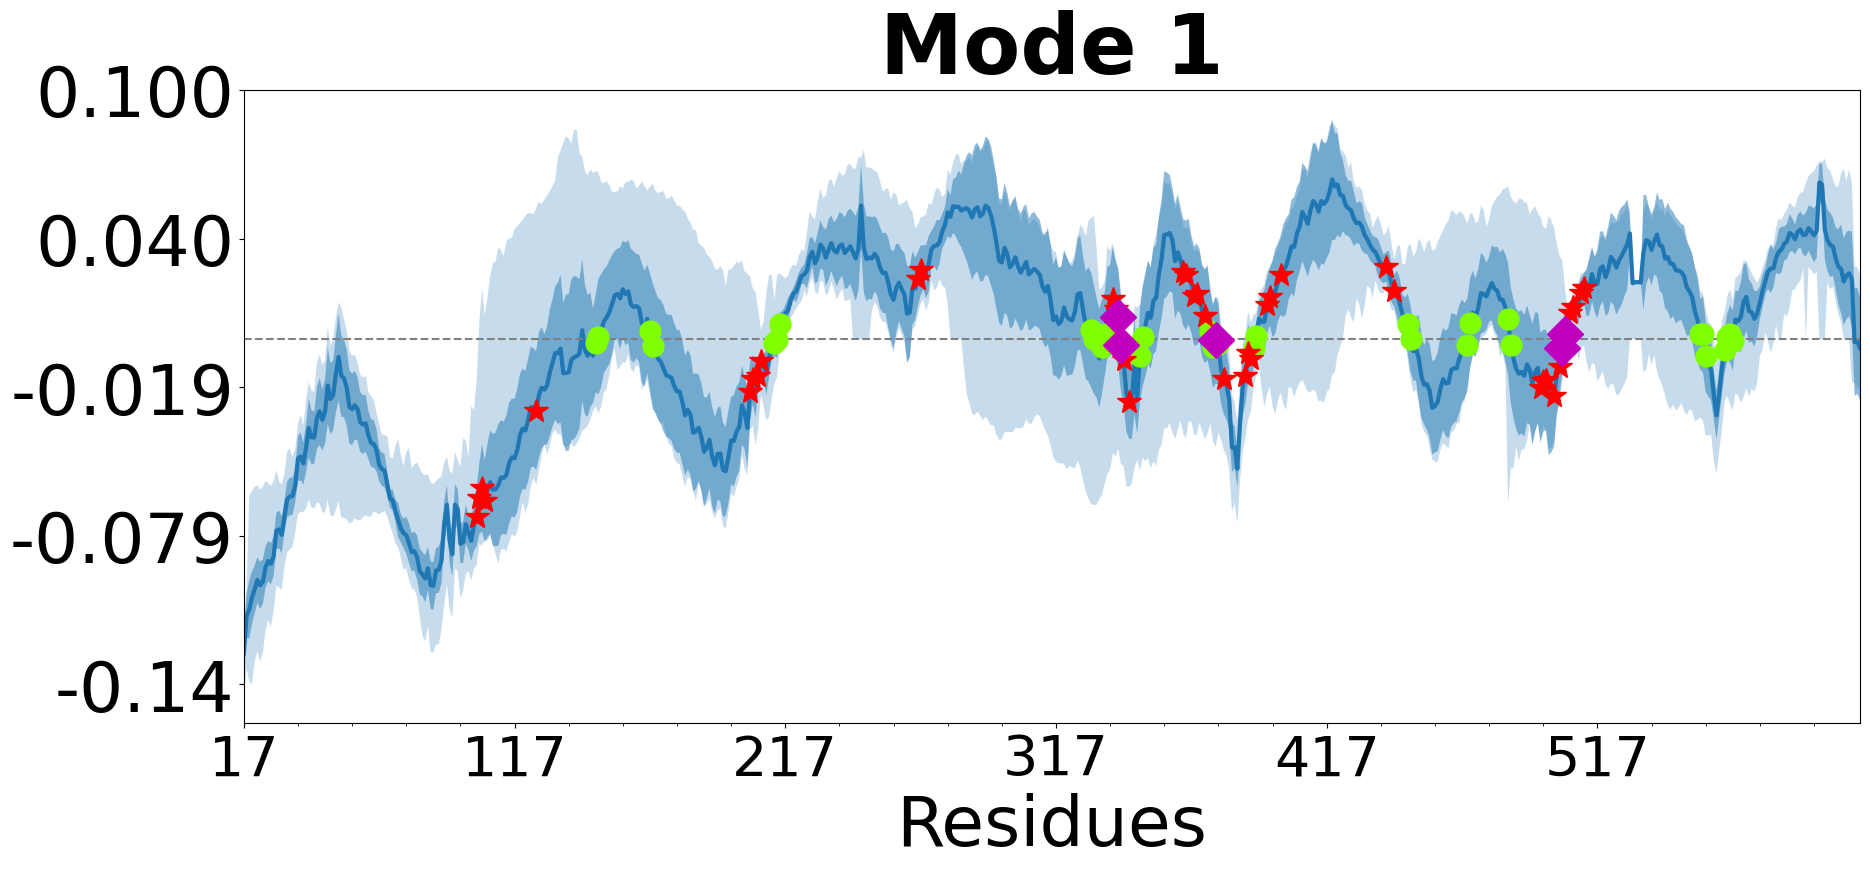

In [329]:
modes = 0 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [262, 263, 491, 492, 570, 86, 87, 568, 569, 410, 411, 571]
local loop motion []
current bindings are [86, 87, 88, 89, 108, 187, 188, 190, 191, 249, 250, 321, 322, 323, 324, 325, 327, 347, 348, 351, 352, 355, 359, 362, 370, 371, 372, 378, 379, 383, 422, 425, 479, 480, 481, 484, 486, 487, 488, 490, 491, 494, 495]
current hits are [86, 87, 491]
# of overlaps finding from current mode is 3


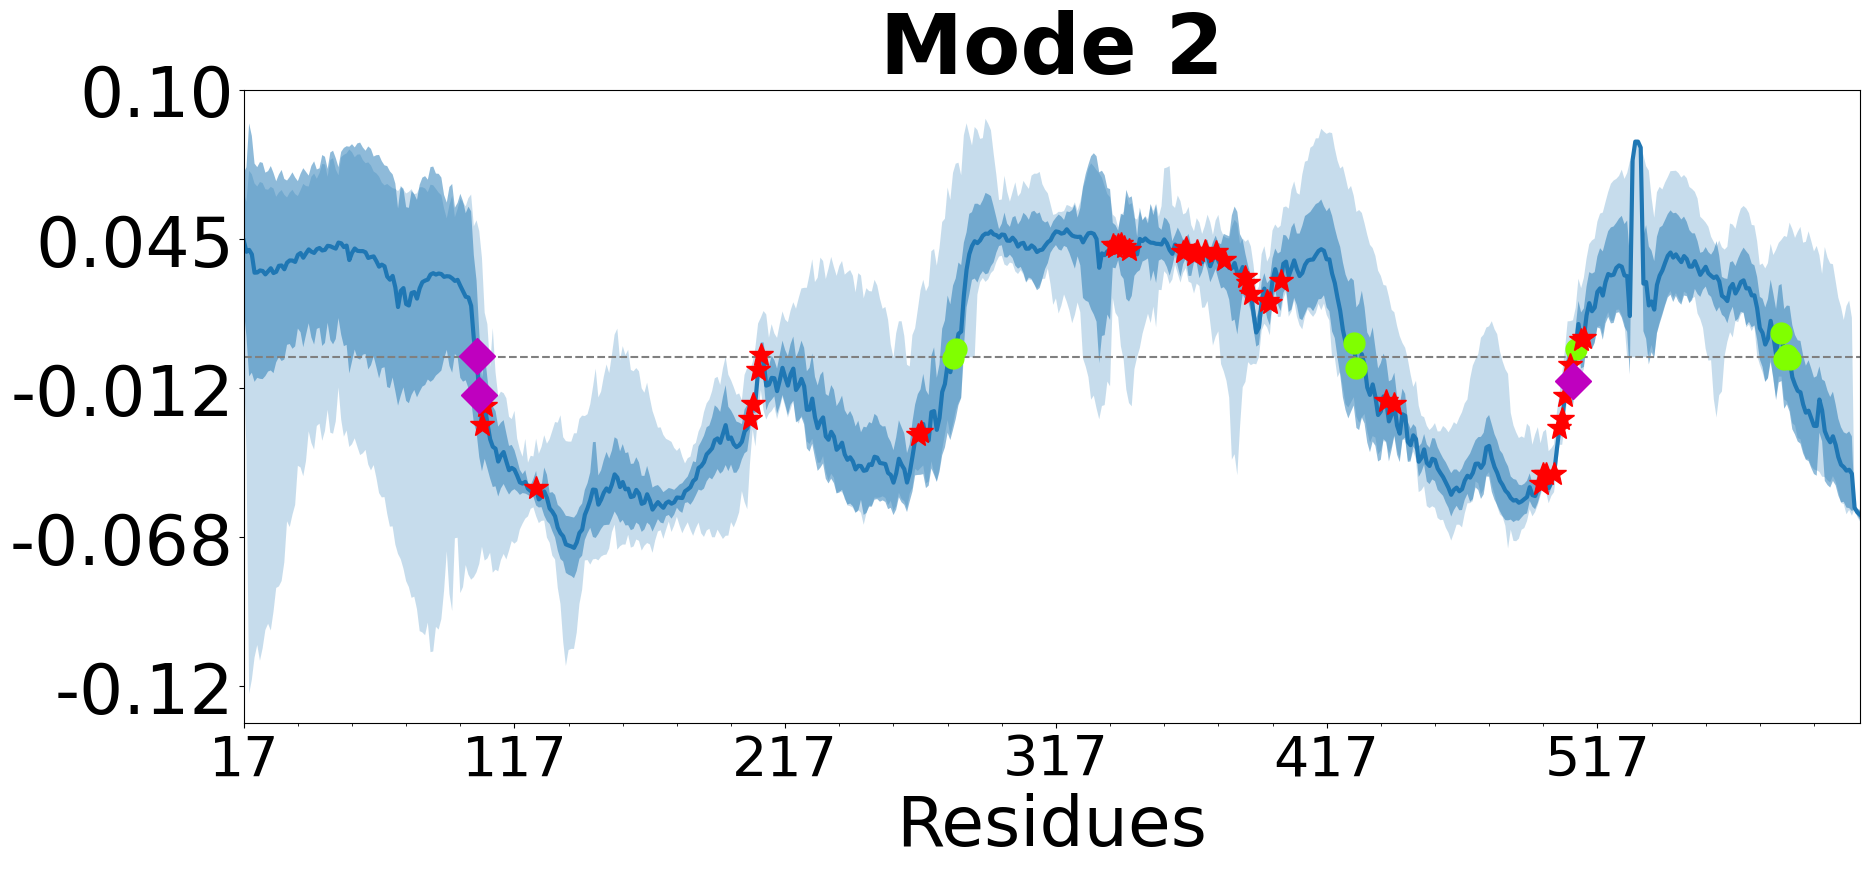

In [330]:
modes = 1 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [389, 390, 136, 137, 266, 267, 392, 393, 142, 143, 525, 401, 402, 526, 20, 21, 527, 528, 529, 530, 431, 432, 433, 434, 53, 54, 188, 189, 190, 452, 453, 467, 468, 86, 87, 359, 360, 487, 488, 377, 378, 379, 380]
local loop motion []
current bindings are [86, 87, 88, 89, 108, 187, 188, 190, 191, 249, 250, 321, 322, 323, 324, 325, 327, 347, 348, 351, 352, 355, 359, 362, 370, 371, 372, 378, 379, 383, 422, 425, 479, 480, 481, 484, 486, 487, 488, 490, 491, 494, 495]
current hits are [86, 87, 188, 190, 359, 378, 379, 487, 488]
# of overlaps finding from current mode is 9


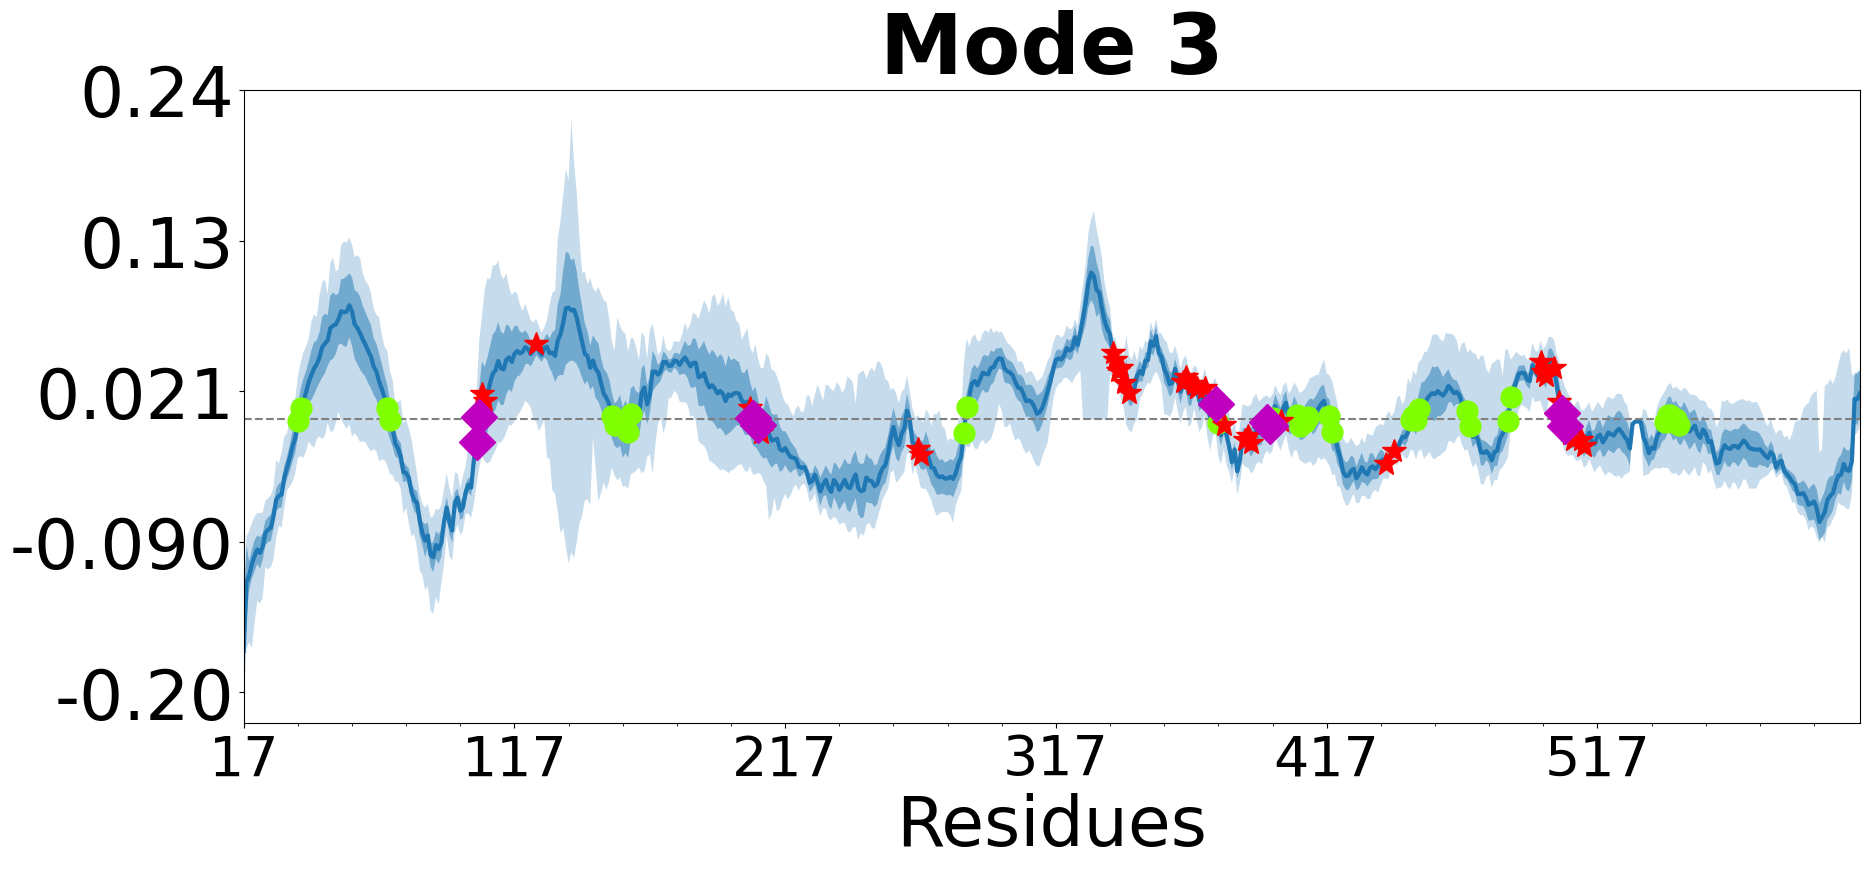

In [331]:
modes = 2 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

In [43]:
def plotSingleGraph_method3(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(15, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3)

    # Hinges within band
    # method3
    currHinge = getHinges_modes3(averageEigVects, mode, Hinge, bandWidth = 15)
    
    
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', currHinge)
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # extraHinges for local loops
    # updateHinge = [item for item in Hinge if item not in currHinge]
    # HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    # print ('local loop motion', updateHinge)
    # plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=18)
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18)

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 
    
    plt.tight_layout()
    plt.savefig('./GR_method3_mode' + str(mode + 1) + '.png', dpi=500)

In [ ]:
modes = 0 # Example modes
plotSingleGraph_method3(modes, averageEigVects, gnms, binding, Hinge0)

In [ ]:
modes = 1 # Example modes
plotSingleGraph_method3(modes, averageEigVects, gnms, binding, Hinge0)

In [ ]:
modes = 2 # Example modes
plotSingleGraph_method3(modes, averageEigVects, gnms, binding, Hinge0)

In [295]:
def plotGraph_figure2(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(25, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3)

    # Hinges within band
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=20)
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', currHinge)
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15, label='1')

    # extraHinges for local loops
    updateHinge = [item for item in Hinge if item not in currHinge]
    HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    print ('local loop motion', updateHinge)
    plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=25,label='3')
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = updateHinge + currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18, label='4')

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 
    
    plt.legend(loc='lower right', ncol=3, fontsize='small')
    
    plt.tight_layout()
    plt.savefig('./figure2_C_update.png', dpi=500)

Hinge residue with wide bands [130, 131, 150, 151, 538, 539, 540, 547, 548, 549, 550, 430, 431, 313, 314, 317, 318, 323, 196, 197, 198, 324, 452, 453, 331, 332, 594, 467, 468, 595, 596, 357, 358, 359, 360, 487, 488, 373, 374]
local loop motion []
current bindings are [86, 87, 88, 89, 108, 187, 188, 190, 191, 249, 250, 321, 322, 323, 324, 325, 327, 347, 348, 351, 352, 355, 359, 362, 370, 371, 372, 378, 379, 383, 422, 425, 479, 480, 481, 484, 486, 487, 488, 490, 491, 494, 495]
current hits are [323, 324, 359, 487, 488]
# of overlaps finding from current mode is 5


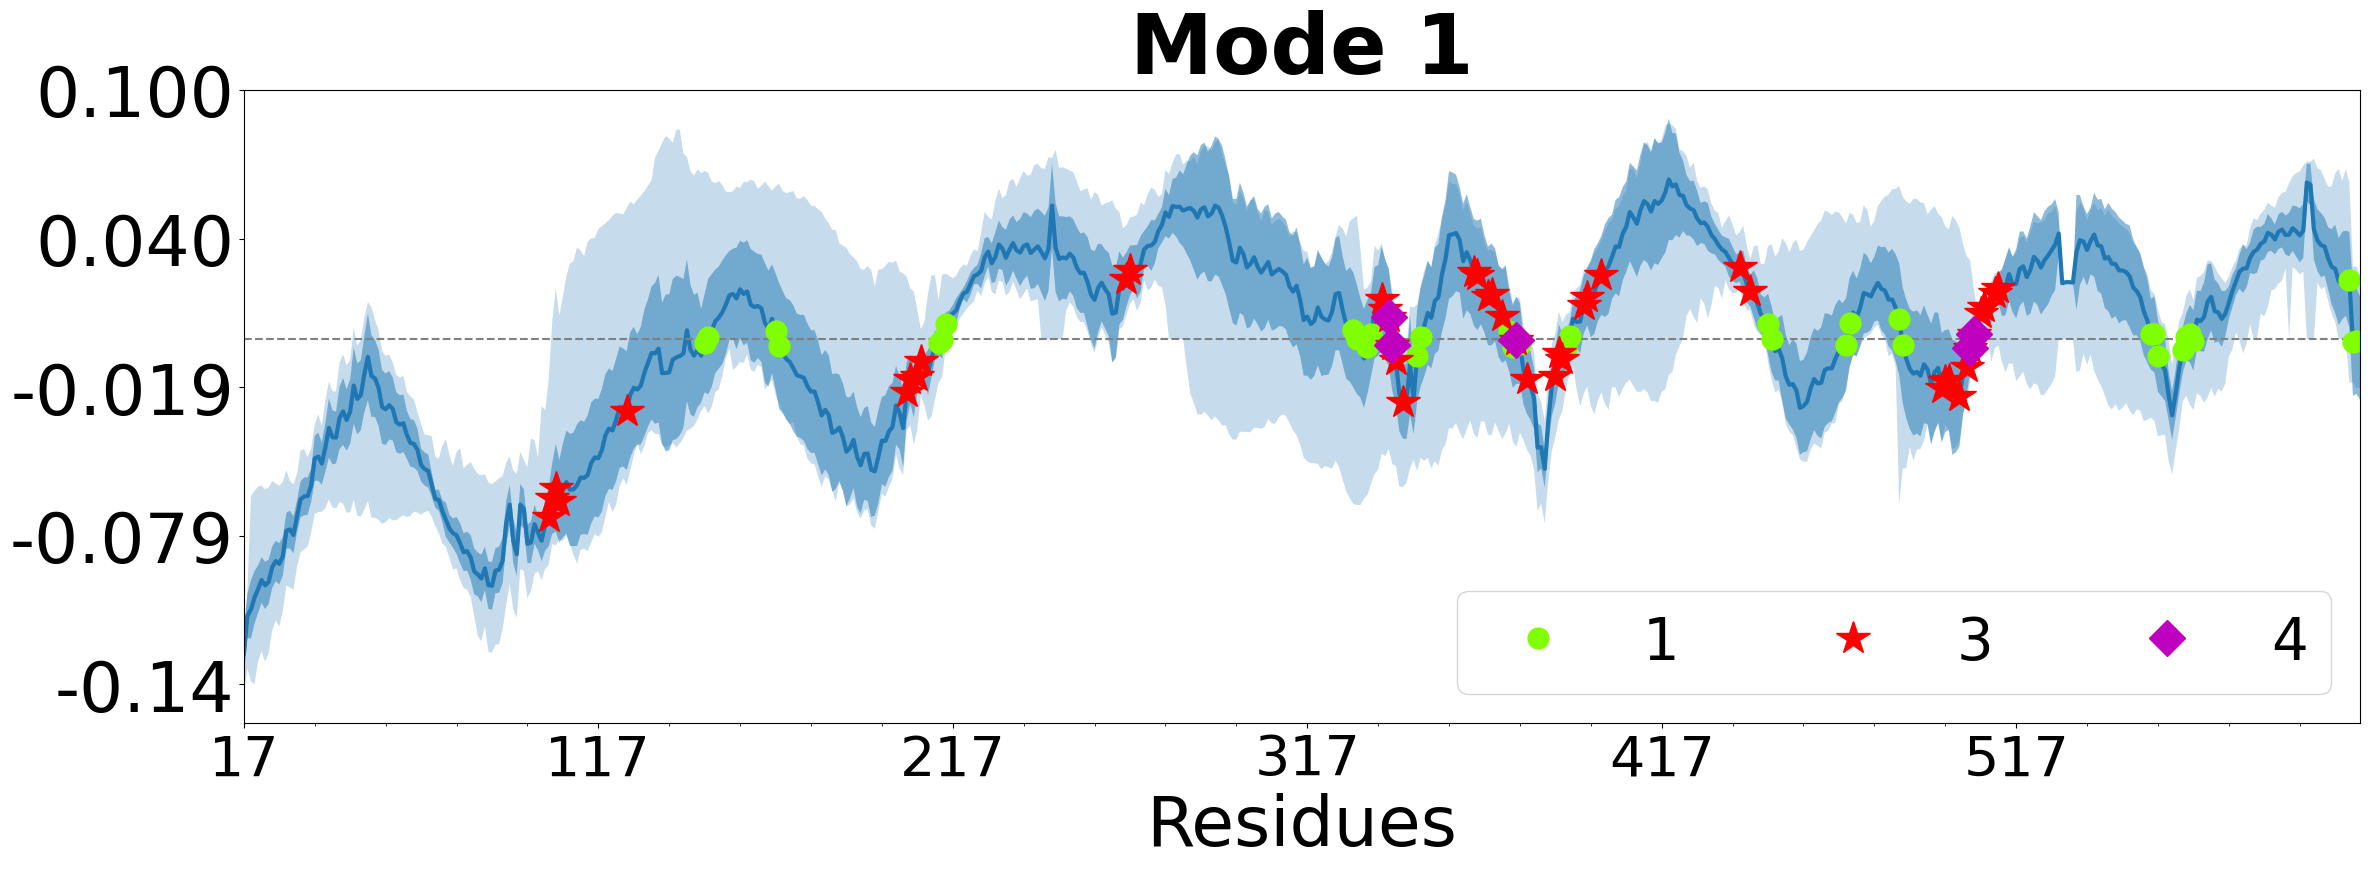

In [296]:
# Calling the function for 4 modes:
modes = 0 # Example modes
plotGraph_figure2(modes, averageEigVects, gnms, binding, [])

# CalcRMSDs from Dali

In [297]:
# Initialize an empty dictionary to store the PDB IDs and RMSD values
pdb_rmsd_dict = {}

# Open the file and extract the information
with open('2x92A_dali.txt', 'r') as file:
    # Read the file line by line
    isStart = False
    for line in file:
        # print(line)
        if "# No:  Chain   Z    rmsd lali nres  %id PDB  Description" in line:
            isStart = True
        if "# Structural equivalences" in line:
            isStart = False
        
        # Check if the line starts with a number followed by a colon, which indicates the start of the relevant data
        if isStart and line.strip() != '':
            # Split the line into columns based on whitespace
            columns = line.split()
            
            # Extract the PDB ID and chain, and format it by removing the dash and making it uppercase
            pdb_chain = columns[1].replace('-', '').upper()
            
            # Extract the RMSD value
            rmsd = columns[3]
            length = columns[4]
            
            # Add the information to the dictionary
            pdb_rmsd_dict[pdb_chain] = [rmsd, length]

# Print the dictionary to check
for key, value in pdb_rmsd_dict.items():
    print(f"{key}: {value}")

NO:: ['Z', 'rmsd']
2X92A: ['0.0', '599']
2XHMA: ['0.3', '599']
2X94A: ['0.1', '599']
2X97A: ['0.2', '599']
2X95A: ['0.2', '599']
2X93A: ['0.1', '599']
2X90A: ['0.1', '598']
4CA8A: ['0.3', '599']
4AA1A: ['0.1', '598']
2X91A: ['0.2', '595']
2X8ZA: ['0.1', '598']
2X8YA: ['0.2', '595']
4AA2A: ['0.2', '598']
2X96A: ['0.2', '598']
4ASRA: ['0.2', '598']
4ASQA: ['0.2', '598']
3ZQZA: ['0.3', '596']
4CA7A: ['0.3', '596']
5A2RA: ['0.4', '597']
1J36B: ['0.5', '592']
1J36A: ['0.5', '592']
1J38A: ['0.6', '592']
1J38B: ['0.6', '592']
1J37B: ['0.6', '592']
1J37A: ['0.6', '592']
6S1YA: ['0.8', '595']
6S1ZA: ['0.8', '585']
4BZSB: ['1.4', '585']
1UZEA: ['1.1', '574']
7Z70A: ['1.2', '575']
2YDMA: ['1.1', '574']
5AMAB: ['1.2', '581']
6F9RA: ['1.2', '581']
5AM9B: ['1.2', '581']
1O86A: ['1.2', '574']
5AMAA: ['1.2', '579']
4UFBA: ['1.3', '579']
7Q24A: ['1.2', '581']
4UFBD: ['1.2', '581']
2OC2A: ['1.2', '581']
3BKLA: ['1.2', '579']
7Q27A: ['1.2', '582']
5AMAD: ['1.2', '579']
2XYDA: ['1.4', '581']
4CA6B: ['1.2'

In [298]:
len(pdb_rmsd_dict)

738

In [304]:
FinalRmsds = []
length = 598

for item in ids:
    currLength = pdb_rmsd_dict[item.upper()][1]
    currRMSD = pdb_rmsd_dict[item.upper()][0]
    # print (currLength, currRMSD)
    if float(currRMSD) >= 1:
        if int(currLength) <= 628 and int(currLength) >= 569: 
            FinalRmsds.append(pdb_rmsd_dict[item.upper()][0])

In [306]:
len(FinalRmsds)

514

In [307]:
with open('ACE_diverseEnsemble.txt', 'w') as wf:
    for rmsd in FinalRmsds:
        wf.write(rmsd + '\n')